# Code to compare one-minute, one-second and Gillespie simulation


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

## First, calculate theoretical mean protein levels


In [2]:
def calculate_protein_level_with_regulation(params, hill_response=0.0, r_add=10, 
                                          splicing_half_life=7/60):
    """
    Calculate steady-state protein level given gene parameters and regulatory input.
    
    Args:
        params (array-like): Gene parameters in order:
            [k_on, k_off, burst_size, mrna_half_life, protein_half_life, protein_production_rate]
        hill_response (float): Desired Hill function output (0-1)
            0 = no regulation, 1 = maximum activation
        r_add (float): Maximum regulatory effect strength (default 10)
        splicing_half_life (float): mRNA maturation time (hours, default 7 min)
    
    Returns:
        float: Steady-state protein level
    """
    
    # Unpack parameters in order
    k_on, k_off, burst_size, mrna_half_life, protein_half_life, protein_production_rate = params
    
    # Convert half-lives to degradation rates
    mrna_deg_rate = np.log(2) / mrna_half_life
    protein_deg_rate = np.log(2) / protein_half_life
    splicing_rate = np.log(2) / splicing_half_life
    
    # Calculate transcription rate from burst parameters
    transcription_rate = burst_size * k_off
    
    
    # Apply regulation: k_on_eff = k_on + r_add * hill_response
    k_on_eff = k_on + r_add * hill_response
    k_on_eff = max(k_on_eff, 1e-10)  # Ensure positive
    
    # Calculate steady-state levels through the cascade
    # 1. Bursting probability
    burst_prob = k_on_eff / (k_on_eff + k_off)
    
    # 2. Unspliced mRNA level
    unspliced_mrna = transcription_rate * burst_prob / (mrna_deg_rate)
    
    # 3. Spliced mRNA level  
    spliced_mrna = unspliced_mrna
    
    # 4. Protein level
    protein_level = spliced_mrna * protein_production_rate / protein_deg_rate
    # print(unspliced_mrna + spliced_mrna)
    return protein_level

In [24]:
params_gene_1 = [0.4023188424412684,69.57850258396365,29.902655460974103,4.9676607542185085,17.514301786039532,0.029712484672261147]
params_gene_2 = [0.2127851341068382,31.933683905796215,79.28488335937969,5.548348142938958,88.7951704914292,0.14608750436112627]
# params_gene_1 = [0.27,8.4,32.0,2.5,28.0,0.059]
# params_gene_2 = [0.25,7.7,40.0,3.7,28,0.059]

r_add = 2

# Calculate equations for gene_1
baseline_gene_1 = calculate_protein_level_with_regulation(params_gene_1, splicing_half_life=7/60)
K_gene_1 = calculate_protein_level_with_regulation(params_gene_1, r_add=r_add, hill_response=0.5, splicing_half_life=7/60)
maximal_gene_1 = calculate_protein_level_with_regulation(params_gene_1, r_add=r_add, hill_response=1, splicing_half_life=7/60)

# Calculate equations for gene_2
baseline_gene_2 = calculate_protein_level_with_regulation(params_gene_2, splicing_half_life=7/60)
K_gene_2 = calculate_protein_level_with_regulation(params_gene_2, r_add=r_add, hill_response=0.5, splicing_half_life=7/60)
maximal_gene_2 = calculate_protein_level_with_regulation(params_gene_2, r_add=r_add, hill_response=1, splicing_half_life=7/60)

# Print results
print("Gene 1:", baseline_gene_1, K_gene_1, maximal_gene_1)
print("Gene 2:", baseline_gene_2, K_gene_2, maximal_gene_2)

Gene 1: 64.35895431409479 221.16856015588675 373.6211830476544
Gene 2: 2510.513825577391 13877.17945351818 24578.08572492592


In [4]:
def compare_sim_to_theory(singleTime_df, gene_name, theoretical_mean, save_path=None):
    fig, ax1 = plt.subplots()

    # Plot histogram on the first y-axis
    ax1.hist(singleTime_df[f'{gene_name}_protein'], bins=100, alpha=0.5, label=f'{gene_name.replace("_", " ")} Protein', color='blue')
    ax1.set_xlabel('Protein Levels')
    ax1.set_ylabel('Frequency', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axvline(singleTime_df[f'{gene_name}_protein'].mean(), label="Simulation Mean", linestyle="--", color="black")
    ax1.axvline(theoretical_mean, label="Theoretical Mean", linestyle="--", color="red")

    # Add legend
    ax1.legend()
    plt.title(f'Protein levels of {gene_name.replace("_", " ")} with one-second resolution\n Theoretical mean = {theoretical_mean:.3e}\n Actual mean = {singleTime_df[f"{gene_name}_protein"].mean():.3e}')

    fig.tight_layout()

    # Save the figure if save_path is provided
    if save_path:
        fig.savefig(save_path + ".png", format='png', dpi=300, bbox_inches='tight')
        fig.savefig(save_path + ".svg", format='svg', bbox_inches='tight')
    plt.show()
    return 


## One minute resolution


In [7]:
sim_one_min

,gene_1_is_bursting,gene_1_unspliced_mRNA,gene_1_spliced_mRNA,gene_1_protein,gene_1_k_on_adjusted,gene_1_k_off_adjusted,gene_1_total_mRNA,gene_1_mRNA_ever_produced,gene_1_protein_ever_produced,gene_2_is_bursting,...,gene_2_spliced_mRNA,gene_2_protein,gene_2_k_on_adjusted,gene_2_k_off_adjusted,gene_2_total_mRNA,gene_2_mRNA_ever_produced,gene_2_protein_ever_produced,cell_id,timestep,replicate
0,1.0,32.60,0.0,97.608594,0.27,0.0,32.60,2777.60,581.728515,0.0,...,0.0,558.307021,1.545787,0.0,327.200000,12905.200000,3983.581863,0,0,0
1,0.0,11.80,0.0,55.312680,0.27,0.0,11.80,2956.80,621.814373,0.0,...,0.0,448.451525,0.992838,0.0,248.266667,13947.266667,4308.973288,1,0,0
2,0.0,111.88,0.0,103.684265,0.27,0.0,111.88,2938.88,610.356613,0.0,...,0.0,498.987311,1.599858,0.0,168.133333,11709.133333,3690.088658,2,0,0
3,0.0,19.92,0.0,102.471044,0.27,0.0,19.92,2311.68,503.074277,0.0,...,0.0,809.381567,1.589486,0.0,362.266667,10944.266667,3354.349354,3,0,0
4,0.0,16.56,0.0,69.696817,0.27,0.0,16.56,2455.04,507.779842,0.0,...,0.0,549.689295,1.218097,0.0,342.466667,12838.466667,3887.833451,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.0,30.76,0.0,70.988315,0.27,0.0,30.76,2750.72,571.075435,0.0,...,0.0,574.195315,1.236447,0.0,275.400000,13182.400000,3992.680057,9995,1440,1
499996,0.0,33.68,0.0,79.093925,0.27,0.0,33.68,2647.68,547.731338,0.0,...,0.0,484.965547,1.344286,0.0,204.800000,10194.800000,3167.908174,9996,1440,1
499997,0.0,38.92,0.0,34.326656,0.27,0.0,38.92,2517.76,528.177125,0.0,...,0.0,462.717392,0.620766,0.0,109.666667,11575.666667,3651.605514,9997,1440,1
499998,0.0,34.44,0.0,42.959835,0.27,0.0,34.44,1693.44,350.481633,0.0,...,0.0,455.024472,0.775546,0.0,173.133333,11170.133333,3487.851867,9998,1440,1


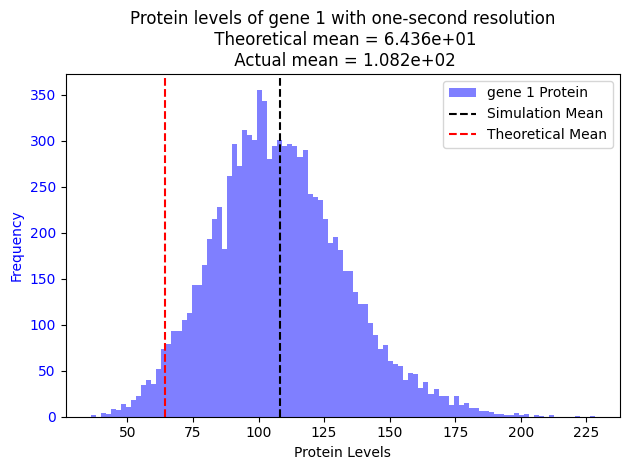

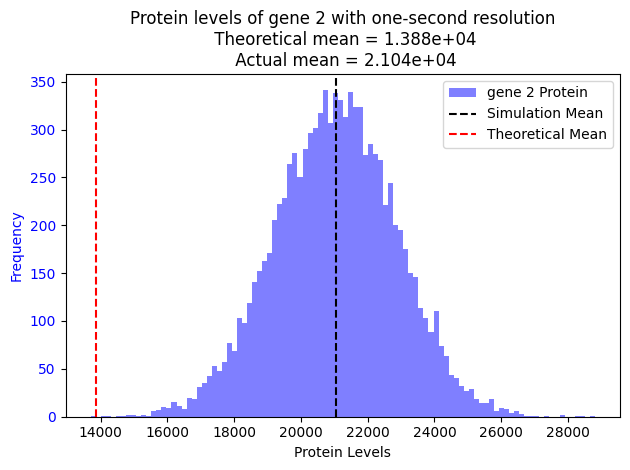

In [26]:
sim_one_min = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/general_simulation_data/test/simulation_matrix101_A_B_different_params_12_13_one_min_step_no_splicing.csv')
time = 300
singleTime_df_one_min = sim_one_min[(sim_one_min['timestep'] == time) & (sim_one_min['replicate'] == 0)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = K_gene_2
compare_sim_to_theory(singleTime_df_one_min, "gene_1", theoretical_mean_1, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/one_min_res_vs_theory_gene_1_extreme")
compare_sim_to_theory(singleTime_df_one_min, "gene_2", theoretical_mean_2, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/one_min_res_vs_theory_gene_2_extreme")

## One-second resolution


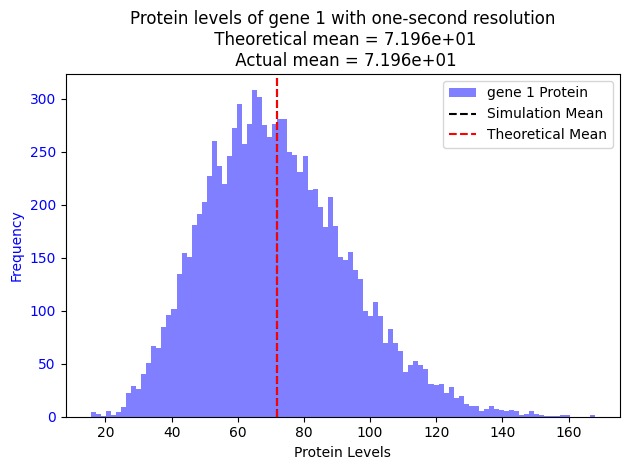

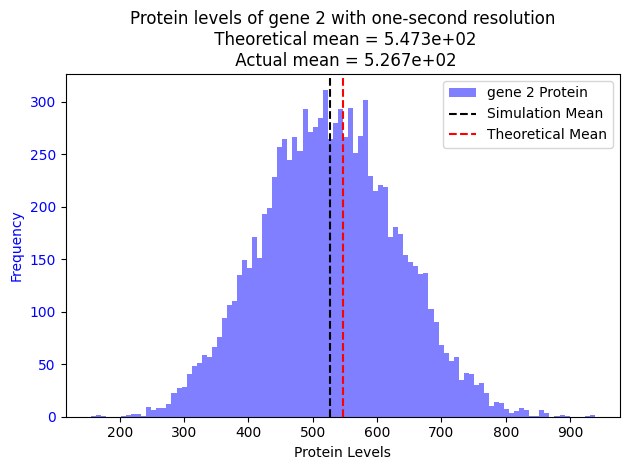

In [21]:
sim_one_sec = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/general_simulation_data/test/simulation_matrix101_A_B_different_params_0_11_one_second_step_no_splicing.csv')
time = 300*60
singleTime_df_one_second = sim_one_sec[(sim_one_sec['timestep'] == time) & (sim_one_sec['replicate'] == 0)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = K_gene_2
compare_sim_to_theory(singleTime_df_one_second, "gene_1", theoretical_mean_1, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/one_sec_res_vs_theory_gene_1")
compare_sim_to_theory(singleTime_df_one_second, "gene_2", theoretical_mean_2, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/one_sec_res_vs_theory_gene_2")

## Gillespie simulation with 1000 cells


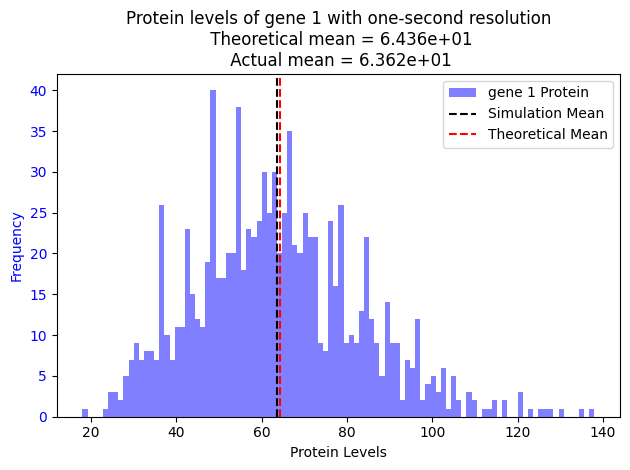

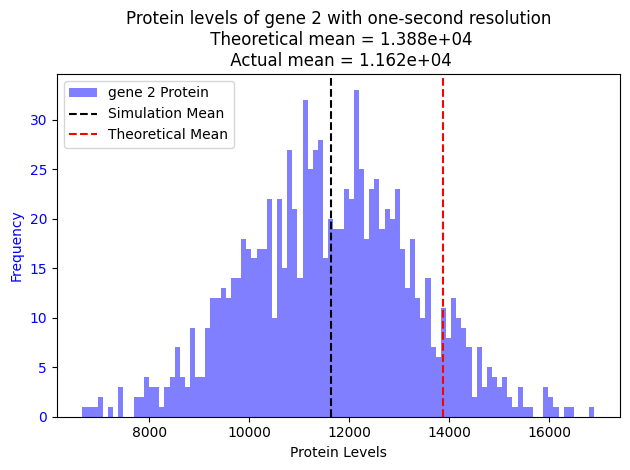

In [27]:
sim_Gillespie_1000_cells = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/gillespie_simulation/test/df_simulation_1000_cells_300h_timepoints_rows_12_13_20250701_203830_800bcb3c.csv')
time = 299
singleTime_df_gillespie = sim_Gillespie_1000_cells[(sim_Gillespie_1000_cells['time_step'] == time)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = K_gene_2
compare_sim_to_theory(singleTime_df_gillespie, "gene_1", theoretical_mean_1 , save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_1000_cells_vs_theory_gene_1")
compare_sim_to_theory(singleTime_df_gillespie, "gene_2", theoretical_mean_2, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_1000_cells_vs_theory_gene_2")

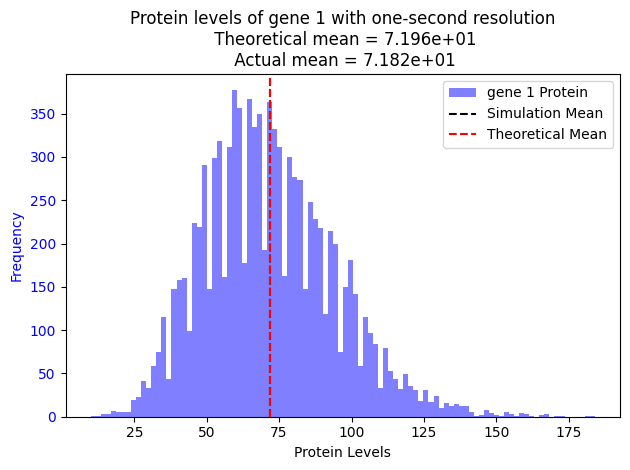

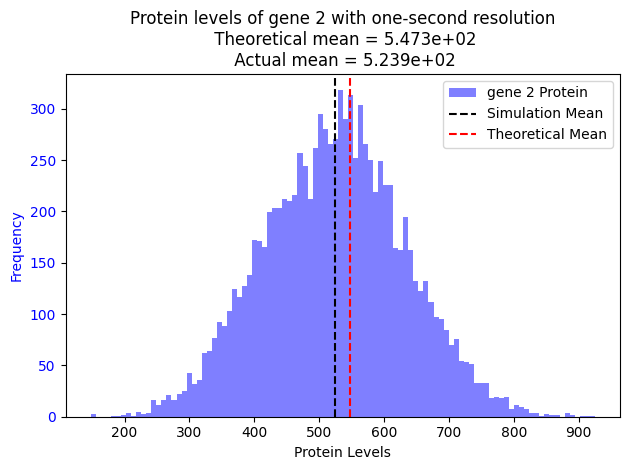

In [19]:
sim_Gillespie_10000_cells = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulation_data/gillespie_simulation/test/df_simulation_10000_cells_300_timepoints_20250701_180020_3b9b9102_.csv')
time = 299
singleTime_df_gillespie_10000 = sim_Gillespie_10000_cells[(sim_Gillespie_10000_cells['tp'] == time)]
theoretical_mean_1 = baseline_gene_1
theoretical_mean_2 = K_gene_2
compare_sim_to_theory(singleTime_df_gillespie_10000, "gene_1", theoretical_mean_1, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_10000_cells_vs_theory_gene_1")
compare_sim_to_theory(singleTime_df_gillespie_10000, "gene_2", theoretical_mean_2, save_path="/home/mzo5929/Keerthana/grnInference/plots/gillespie_vs_one_second_res/gillespie_10000_cells_vs_theory_gene_2")

## Overlap the gillespie simulation with one-second resolution


In [22]:
col = 'gene_1_protein'
data1 = singleTime_df_gillespie_10000[col].dropna().values
data2 = singleTime_df_one_second[col].dropna().values
data3 = singleTime_df_one_min[col].dropna().values


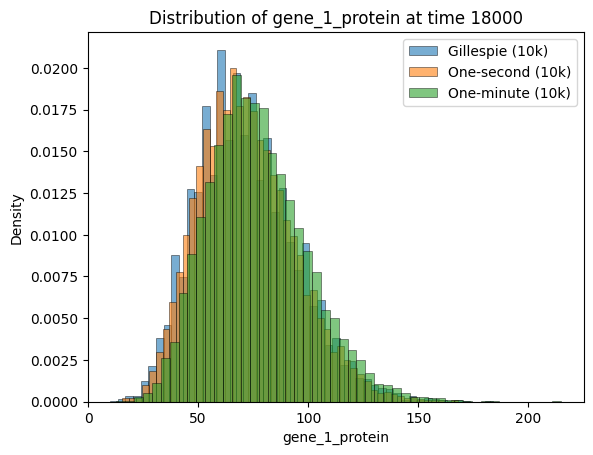

/home/mzo5929/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


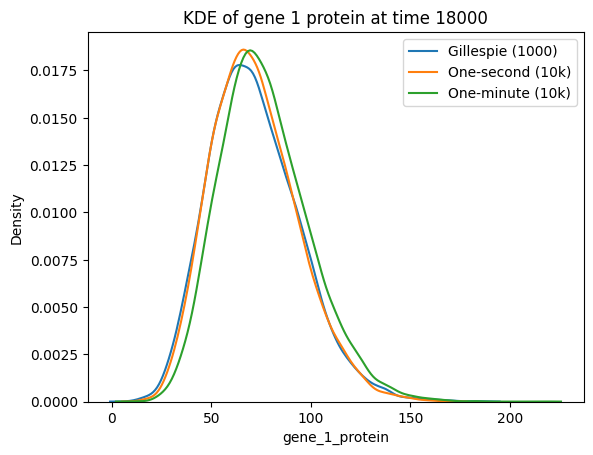

KS statistic for Gillespie vs one second: 0.022, p-value: 1.447e-02
KS statistic for Gillespie vs one minute: 0.106, p-value: 8.937e-50
KS statistic for one second vs one minute: 0.089, p-value: 2.938e-35
Jensen–Shannon divergence for Gillespie vs one second: 0.0585
Jensen–Shannon divergence for Gillespie vs one minute: 0.1054
Jensen–Shannon divergence for one second vs one minute: 0.0900


In [23]:
import matplotlib.pyplot as plt

plt.hist(data1, bins=50, density=True, alpha=0.6, label='Gillespie (10k)', linewidth=0.5, edgecolor='black')
plt.hist(data2, bins=50, density=True, alpha=0.6, label='One-second (10k)', linewidth=0.5, edgecolor='black')
plt.hist(data3, bins=50, density=True, alpha=0.6, label='One-minute (10k)', linewidth=0.5, edgecolor='black')

plt.xlabel(col)
plt.ylabel('Density')
plt.title(f'Distribution of {col} at time {time}')
plt.legend()
plt.show()

import seaborn as sns

sns.kdeplot(data1, label='Gillespie (1000)', bw_adjust=1)
sns.kdeplot(data2, label='One-second (10k)', bw_adjust=1)
sns.kdeplot(data3, label='One-minute (10k)', bw_adjust=1)
plt.xlabel(col)
plt.title(f'KDE of {col.replace("_", " ")} at time {time}')
plt.legend()
plt.show()

from scipy.stats import ks_2samp

ks_stat_1_2, ks_p_1_2 = ks_2samp(data1, data2)
print(f"KS statistic for Gillespie vs one second: {ks_stat_1_2:.3f}, p-value: {ks_p_1_2:.3e}")
ks_stat_1_3, ks_p_1_3 = ks_2samp(data1, data3)
print(f"KS statistic for Gillespie vs one minute: {ks_stat_1_3:.3f}, p-value: {ks_p_1_3:.3e}")
ks_stat_2_3, ks_p_2_3 = ks_2samp(data2, data3)
print(f"KS statistic for one second vs one minute: {ks_stat_2_3:.3f}, p-value: {ks_p_2_3:.3e}")

from scipy.spatial.distance import jensenshannon
import numpy as np
# Create histograms with same bins
hist1, bins = np.histogram(data1, bins=100, range=(min(data1.min(), data2.min(), data3.min()), max(data1.max(), data2.max(), data3.max())), density=True)
hist2, _ = np.histogram(data2, bins=bins, density=True)
hist3, _ = np.histogram(data3, bins=bins, density=True)

# Calculate Jensen–Shannon divergence
js_div_1_2 = jensenshannon(hist1, hist2)
js_div_1_3 = jensenshannon(hist1, hist3)
js_div_2_3 = jensenshannon(hist2, hist3)

print(f"Jensen–Shannon divergence for Gillespie vs one second: {js_div_1_2:.4f}")
print(f"Jensen–Shannon divergence for Gillespie vs one minute: {js_div_1_3:.4f}")
print(f"Jensen–Shannon divergence for one second vs one minute: {js_div_2_3:.4f}")
